# CGS616 Assignment 2: Dynamic Computational Model of Latent Cognitive States
## Markov Chain / HMM-Based Behavioral Modeling with Reinforcement Learning
This notebook builds a Hidden Markov Model (HMM) with sigmoid-based state transitions and a Q-Learning RL extension to model how latent cognitive states evolve over time during crisis events.

## 1. Setup & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import expit  # sigmoid
from sklearn.model_selection import KFold
from collections import Counter

np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11, 'figure.dpi': 150})
%matplotlib inline

print("✓ All imports successful")

✓ All imports successful


## 2. Helper Functions
### Country Classification & State MappingWe reuse the ABC behavioral framework** from Assignment 1:
State A (Action): caution, rescue/donation, sympathy → prosocial response
State B (Impact): injuries, displacement, infrastructure damage → suffering/distress*  
State C (Info): other information, requests → neutral information

Antecedent (Xt): Global North (1) vs. Global South (0)  
Latent State (St):0 (passive/impact) or 1 (active/engaged)

In [2]:
def get_global_north_countries():
    return [
        'United States', 'USA', 'Canada',
        'United Kingdom', 'UK', 'Great Britain', 'England',
        'Germany', 'France', 'Italy', 'Spain', 'Netherlands', 'Belgium',
        'Sweden', 'Norway', 'Denmark', 'Finland', 'Switzerland', 'Austria',
        'Ireland', 'Luxembourg',
        'Australia', 'New Zealand',
        'Japan', 'South Korea', 'Singapore', 'Israel'
    ]

def classify_country(country_name, global_north_list):
    if not isinstance(country_name, str):
        return 0
    country_norm = country_name.strip()
    if country_norm in global_north_list:
        return 1
    for gn in global_north_list:
        if gn.lower() in country_norm.lower():
            return 1
    return 0

def get_behavioral_state(label):
    cool_labels = {'caution_and_advice', 'rescue_volunteering_or_donation_effort', 'sympathy_and_support'}
    warm_labels = {'injured_or_dead_people', 'displaced_people_and_evacuations', 'not_humanitarian',
                   'infrastructure_and_utility_damage', 'missing_or_found_people'}
    if label in cool_labels: return 0   # Action
    if label in warm_labels: return 1   # Impact
    return 2                            # Info

def get_latent_state(behavior_state):
    return 0 if behavior_state == 1 else 1

BEHAVIOR_NAMES = {0: 'Action', 1: 'Impact', 2: 'Info'}
LATENT_NAMES = {0: 'Passive/Impact', 1: 'Active/Engaged'}
REWARD_MAP = np.array([1.0, -1.0, 0.0])

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Data Loading & Preprocessing

In [3]:
df = pd.read_csv('crisisnlp_combined_dataset.csv')
print(f"Loaded {len(df):,} tweets")

# Classify region as numeric antecedent Xt
gn_list = get_global_north_countries()
df['Xt'] = df['country'].apply(lambda c: classify_country(c, gn_list))
df['region_label'] = df['Xt'].map({1: 'Global North', 0: 'Global South'})

# Observable behavior Bt (integer)
df['Bt'] = df['class_label'].apply(get_behavioral_state)
df['behavior_name'] = df['Bt'].map(BEHAVIOR_NAMES)

# Binary latent state St
df['St'] = df['Bt'].apply(get_latent_state)

# Temporal ordering
df['timestamp'] = pd.to_datetime(df['tweet_time_utc'], errors='coerce')
df = df.dropna(subset=['timestamp'])
df = df.sort_values(['disaster_name', 'timestamp']).reset_index(drop=True)

print(f"After cleaning: {len(df):,} tweets")
print(f"Global North tweets: {(df['Xt'] == 1).sum():,}")
print(f"Global South tweets: {(df['Xt'] == 0).sum():,}")
print(f"Latent state distribution: St=1 (Active) = {df['St'].mean():.3f}")
print()

# Summary table
summary = pd.DataFrame({
    'Region': ['Global North', 'Global South'],
    'Count': [(df['Xt']==1).sum(), (df['Xt']==0).sum()],
    'Active %': [df[df['Xt']==1]['St'].mean()*100, df[df['Xt']==0]['St'].mean()*100],
    'Action %': [(df[df['Xt']==1]['Bt']==0).mean()*100, (df[df['Xt']==0]['Bt']==0).mean()*100],
    'Impact %': [(df[df['Xt']==1]['Bt']==1).mean()*100, (df[df['Xt']==0]['Bt']==1).mean()*100],
    'Info %':   [(df[df['Xt']==1]['Bt']==2).mean()*100, (df[df['Xt']==0]['Bt']==2).mean()*100],
})
summary

Loaded 41,152 tweets
After cleaning: 41,149 tweets
Global North tweets: 24,147
Global South tweets: 17,002
Latent state distribution: St=1 (Active) = 0.669



,Region,Count,Active %,Action %,Impact %,Info %
0,Global North,24147,63.461300,41.379882,36.538700,22.081418
1,Global South,17002,71.891542,50.476415,28.108458,21.415128


## 4. Empirical Transition Analysis
### Transition Matrix: P(S_{t+1} | S_t) 
Before fitting the parametric model, we compute the raw empirical transition probabilities from the data. This gives us a baseline to compare against.

In [4]:
for region_val, region_name in [(1, 'Global North'), (0, 'Global South')]:
    region_df = df[df['Xt'] == region_val]

    # State transitions per disaster
    trans_counts = np.zeros((2, 2))
    for disaster in region_df['disaster_name'].unique():
        dis_df = region_df[region_df['disaster_name'] == disaster]
        states = dis_df['St'].values
        for i in range(len(states) - 1):
            trans_counts[states[i], states[i+1]] += 1

    row_sums = trans_counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    trans_probs = trans_counts / row_sums

    # Emission probabilities P(Bt | St)
    emission_counts = np.zeros((2, 3))
    for st_val in [0, 1]:
        subset = region_df[region_df['St'] == st_val]
        for bt_val in [0, 1, 2]:
            emission_counts[st_val, bt_val] = (subset['Bt'] == bt_val).sum()
    em_sums = emission_counts.sum(axis=1, keepdims=True)
    em_sums[em_sums == 0] = 1
    emission_probs = emission_counts / em_sums

    print(f"\n{'='*50}")
    print(f"  {region_name} (n = {len(region_df):,})")
    print(f"{'='*50}")
    print(f"\n  Transition Matrix P(St+1 | St):")
    print(f"  {'':>20} → Passive(0)    → Active(1)")
    for i in range(2):
        print(f"    From {LATENT_NAMES[i]:>16}:    {trans_probs[i,0]:.4f}        {trans_probs[i,1]:.4f}")

    print(f"\n  Emission Matrix P(Bt | St):")
    print(f"  {'':>20} Action(0)  Impact(1)  Info(2)")
    for i in range(2):
        print(f"    St={LATENT_NAMES[i]:>16}:  {emission_probs[i,0]:.4f}    {emission_probs[i,1]:.4f}    {emission_probs[i,2]:.4f}")


  Global North (n = 24,147)

  Transition Matrix P(St+1 | St):
                       → Passive(0)    → Active(1)
    From   Passive/Impact:    0.4294        0.5706
    From   Active/Engaged:    0.3286        0.6714

  Emission Matrix P(Bt | St):
                       Action(0)  Impact(1)  Info(2)
    St=  Passive/Impact:  0.0000    1.0000    0.0000
    St=  Active/Engaged:  0.6520    0.0000    0.3480

  Global South (n = 17,002)

  Transition Matrix P(St+1 | St):
                       → Passive(0)    → Active(1)
    From   Passive/Impact:    0.3370        0.6630
    From   Active/Engaged:    0.2592        0.7408

  Emission Matrix P(Bt | St):
                       Action(0)  Impact(1)  Info(2)
    St=  Passive/Impact:  0.0000    1.0000    0.0000
    St=  Active/Engaged:  0.7021    0.0000    0.2979


## 5. Parameter Estimation (MLE)
### Sigmoid-Based State Transition Model$$P(S_{t+1} = 1 \mid S_t, X_t) = \sigma(\beta X_t - \delta S_t + \epsilon_t)$$Where $\sigma(z) = \frac{1}{1 + e^{-z}}$
Parameters to estimate:- $\beta$ → sensitivity to stimulus (antecedent effect)- $\delta$ → decay/recovery rate- $\tau$ → noise parameter ($\epsilon_t \sim N(0, \tau^2)$)- Emission logits → $P(B_t | S_t)$**Optimization:** Minimize negative log-likelihood via L-BFGS-B$$\hat{\theta} = \arg\max \mathcal{L}(\theta) = \arg\max \prod P(B_t | S_t(\theta))$$

In [5]:
def compute_neg_log_likelihood(params, St_seq, Xt_seq, Bt_seq):
    beta, delta, tau = params[0], params[1], params[2]
    emit_logits = params[3:].reshape(2, 2)

    # Emission probs via softmax
    emission_probs = np.zeros((2, 3))
    for s in range(2):
        logits_3 = np.array([emit_logits[s, 0], emit_logits[s, 1], 0.0])
        max_l = np.max(logits_3)
        exp_l = np.exp(logits_3 - max_l)
        emission_probs[s] = exp_l / exp_l.sum()

    # Emission log-likelihood (vectorized)
    p_bt = emission_probs[St_seq, Bt_seq]
    p_bt = np.clip(p_bt, 1e-12, None)
    nll = -np.sum(np.log(p_bt))

    # Transition log-likelihood (vectorized)
    St_prev = St_seq[:-1]
    St_curr = St_seq[1:]
    Xt_curr = Xt_seq[1:]
    z = beta * Xt_curr - delta * St_prev
    p_s1 = expit(z)
    p_st = np.where(St_curr == 1, p_s1, 1 - p_s1)
    p_st = np.clip(p_st, 1e-12, None)
    nll -= np.sum(np.log(p_st))

    if tau > 0:
        nll += 0.01 / (tau + 1e-8)

    return nll

print("✓ Negative log-likelihood function defined")

✓ Negative log-likelihood function defined


In [6]:
mle_results = {}

for region_val, region_name in [(1, 'Global North'), (0, 'Global South')]:
    print(f"\n{'='*60}")
    print(f"  Estimating parameters for {region_name}")
    print(f"{'='*60}")
    region_df = df[df['Xt'] == region_val]

    # Build sequences per disaster
    all_St, all_Xt, all_Bt = [], [], []
    for disaster in region_df['disaster_name'].unique():
        dis_df = region_df[region_df['disaster_name'] == disaster]
        all_St.extend(dis_df['St'].values.tolist())
        all_Xt.extend(dis_df['Xt'].values.tolist())
        all_Bt.extend(dis_df['Bt'].values.tolist())

    St_seq = np.array(all_St)
    Xt_seq = np.array(all_Xt)
    Bt_seq = np.array(all_Bt)

    x0 = np.array([0.5, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0])
    print(f"  Optimizing with {len(St_seq):,} observations ...")

    res = minimize(
        compute_neg_log_likelihood, x0,
        args=(St_seq, Xt_seq, Bt_seq),
        method='L-BFGS-B',
        bounds=[(-5,5), (0.01,5), (0.01,5), (-5,5), (-5,5), (-5,5), (-5,5)],
        options={'maxiter': 500, 'ftol': 1e-8}
    )

    beta_hat, delta_hat, tau_hat = res.x[0], res.x[1], res.x[2]
    nll = res.fun
    n_params = len(res.x)
    n_obs = len(St_seq)

    # Emission probs from logits
    emit_logits = res.x[3:].reshape(2, 2)
    emission_probs = np.zeros((2, 3))
    for s in range(2):
        logits_3 = np.array([emit_logits[s, 0], emit_logits[s, 1], 0.0])
        max_l = np.max(logits_3)
        exp_l = np.exp(logits_3 - max_l)
        emission_probs[s] = exp_l / exp_l.sum()

    ll = -nll
    aic = 2 * n_params + 2 * nll
    bic = n_params * np.log(n_obs) + 2 * nll

    # Transition table
    trans_table = {}
    for st_v in [0, 1]:
        for xt_v in [0, 1]:
            z = beta_hat * xt_v - delta_hat * st_v
            trans_table[(st_v, xt_v)] = expit(z)

    eq_north = beta_hat / delta_hat if delta_hat != 0 else float('inf')
    eq_south = 0.0

    mle_results[region_name] = {
        'beta': beta_hat, 'delta': delta_hat, 'tau': tau_hat,
        'log_likelihood': ll, 'aic': aic, 'bic': bic,
        'n_obs': n_obs, 'n_params': n_params,
        'emission_probs': emission_probs, 'trans_table': trans_table,
        'eq_north': eq_north, 'eq_south': eq_south,
        'St_seq': St_seq, 'Xt_seq': Xt_seq, 'Bt_seq': Bt_seq,
    }

    print(f"\n  ✓ Optimization {'converged' if res.success else 'finished'}.")
    print(f"  β (stimulus sensitivity) = {beta_hat:.4f}")
    print(f"  δ (decay/recovery rate)  = {delta_hat:.4f}")
    print(f"  τ (noise parameter)      = {tau_hat:.4f}")
    print(f"  Log-Likelihood           = {ll:.2f}")
    print(f"  AIC                      = {aic:.2f}")
    print(f"  BIC                      = {bic:.2f}")
    print(f"\n  Transition P(St+1=1 | St, Xt):")
    for (st_v, xt_v), p in trans_table.items():
        print(f"    St={st_v}, Xt={xt_v}  →  P(St+1=1) = {p:.4f}")
    print(f"\n  Emission P(Bt | St):")
    for s in range(2):
        print(f"    St={s}: Action={emission_probs[s,0]:.4f}, Impact={emission_probs[s,1]:.4f}, Info={emission_probs[s,2]:.4f}")
    print(f"\n  Equilibrium S* = β/δ · X:")
    print(f"    For Xt=1 (North): S* = {eq_north:.4f}")
    print(f"    For Xt=0 (South): S* = {eq_south:.4f}")


  Estimating parameters for Global North
  Optimizing with 24,147 observations ...



  ✓ Optimization converged.
  β (stimulus sensitivity) = 0.5583
  δ (decay/recovery rate)  = 0.0100
  τ (noise parameter)      = 1.0152
  Log-Likelihood           = -25854.02
  AIC                      = 51722.04
  BIC                      = 51778.69

  Transition P(St+1=1 | St, Xt):
    St=0, Xt=0  →  P(St+1=1) = 0.5000
    St=0, Xt=1  →  P(St+1=1) = 0.6361
    St=1, Xt=0  →  P(St+1=1) = 0.4975
    St=1, Xt=1  →  P(St+1=1) = 0.6337

  Emission P(Bt | St):
    St=0: Action=0.0000, Impact=0.9933, Info=0.0067
    St=1: Action=0.6520, Impact=0.0023, Info=0.3456

  Equilibrium S* = β/δ · X:
    For Xt=1 (North): S* = 55.8336
    For Xt=0 (South): S* = 0.0000

  Estimating parameters for Global South
  Optimizing with 17,002 observations ...

  ✓ Optimization converged.
  β (stimulus sensitivity) = 0.5000
  δ (decay/recovery rate)  = 0.0100
  τ (noise parameter)      = 1.0081
  Log-Likelihood           = -19315.08
  AIC                      = 38644.15
  BIC                      = 38698.34


### Fitted Transition Matrices

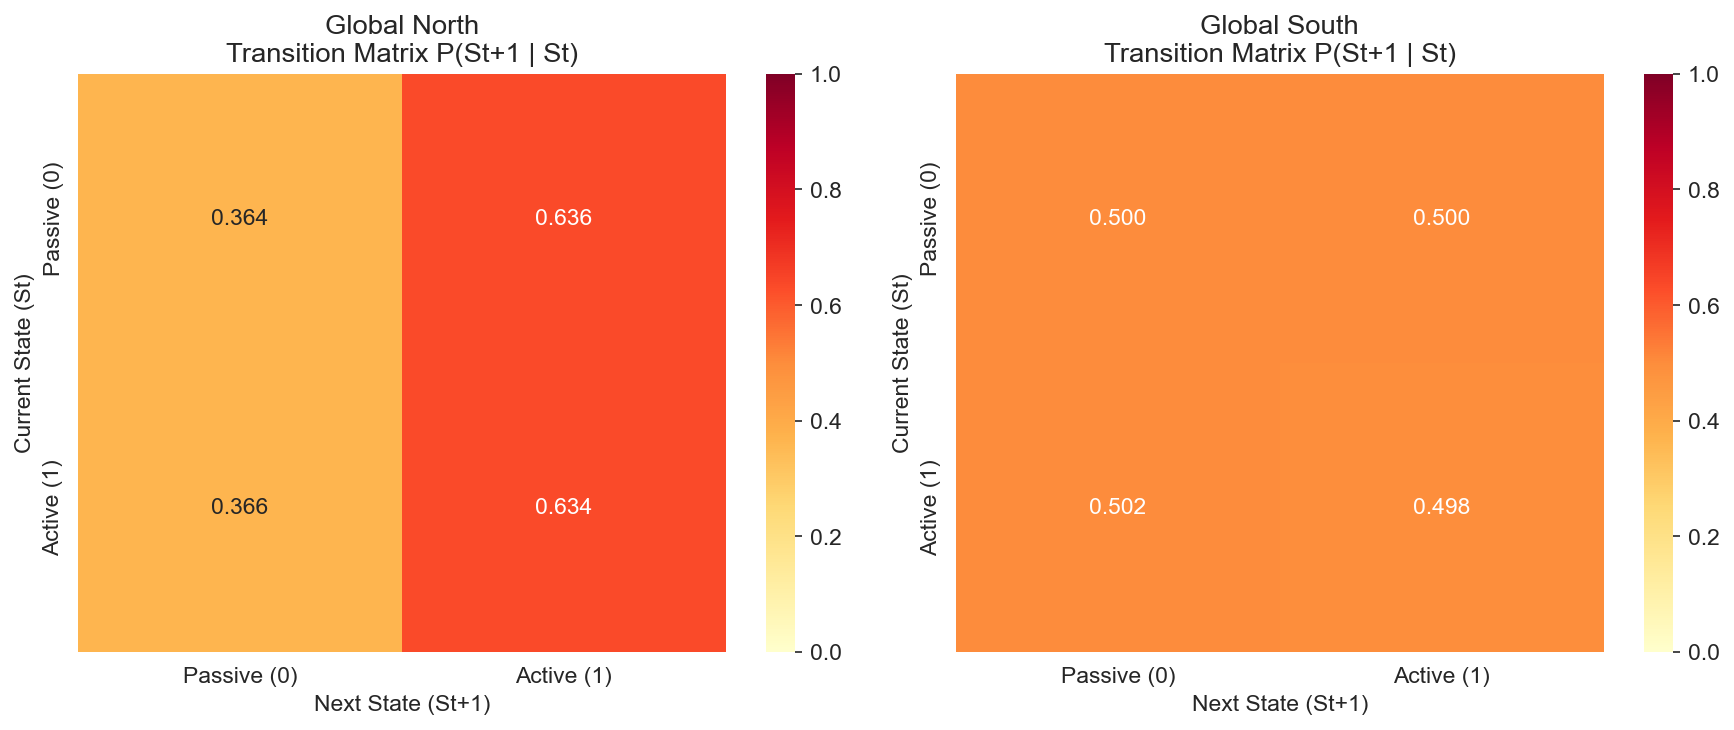

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for idx, region_name in enumerate(['Global North', 'Global South']):
    p = mle_results[region_name]
    trans_mat = np.zeros((2, 2))
    xt_val = 1 if region_name == 'Global North' else 0
    for st in range(2):
        z = p['beta'] * xt_val - p['delta'] * st
        p_s1 = expit(z)
        trans_mat[st, 1] = p_s1
        trans_mat[st, 0] = 1 - p_s1

    sns.heatmap(trans_mat, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=['Passive (0)', 'Active (1)'],
                yticklabels=['Passive (0)', 'Active (1)'],
                ax=axes[idx], vmin=0, vmax=1)
    axes[idx].set_title(f'{region_name}\nTransition Matrix P(St+1 | St)')
    axes[idx].set_xlabel('Next State (St+1)')
    axes[idx].set_ylabel('Current State (St)')
plt.tight_layout()
plt.savefig('plot_transition_matrices.png', bbox_inches='tight')
plt.show()

### Emission Probabilities $P(B_t | S_t)$

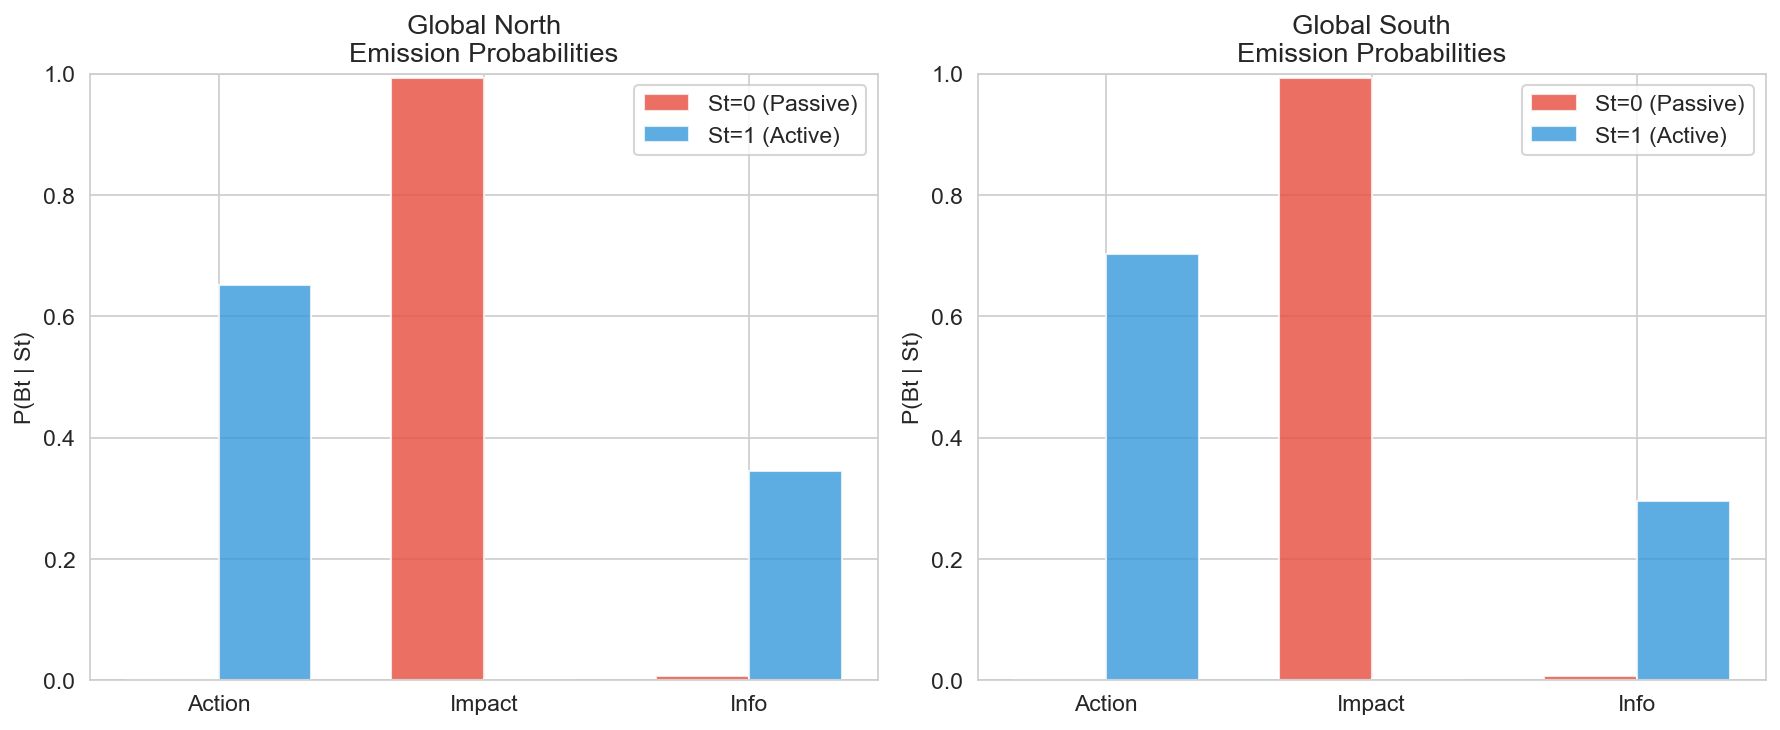

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for idx, region_name in enumerate(['Global North', 'Global South']):
    p = mle_results[region_name]
    em = p['emission_probs']
    x_pos = np.arange(3)
    w = 0.35
    axes[idx].bar(x_pos - w/2, em[0], w, label='St=0 (Passive)', color='#e74c3c', alpha=0.8)
    axes[idx].bar(x_pos + w/2, em[1], w, label='St=1 (Active)', color='#3498db', alpha=0.8)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(['Action', 'Impact', 'Info'])
    axes[idx].set_ylabel('P(Bt | St)')
    axes[idx].set_title(f'{region_name}\nEmission Probabilities')
    axes[idx].legend()
    axes[idx].set_ylim(0, 1)
plt.tight_layout()
plt.savefig('plot_emission_probs.png', bbox_inches='tight')
plt.show()

## 6. Q-Learning Reinforcement Learning Model
### Q-Value Update Rule$$Q_{t+1} = Q_t + \alpha(r_t - Q_t)$$
### Softmax Behavior Probability$$P(B_t) = \frac{e^{Q_t / \tau}}{\sum e^{Q_t / \tau}}$$
Parameters: $\alpha$ = learning rate (high → rapid habit formation, low → gradual reinforcement)- $\tau$ = temperature (low → exploitative/deterministic, high → exploratory/noisy)

Reward signal: Action → +1 (prosocial engagement)- Impact → -1 (distress)  - Info → 0 (neutral)

In [9]:
def _qlearn_sequences(df, region_val):
    region_df = df[df['Xt'] == region_val]
    sequences = []
    for disaster in region_df['disaster_name'].unique():
        dis_df = region_df[region_df['disaster_name'] == disaster]
        sequences.append(dis_df['Bt'].values.astype(int))
    return sequences, len(region_df)

def _qlearn_ll(sequences, alpha, tau_rl):
    ll = 0.0
    for bt_seq in sequences:
        Q = np.zeros(3)
        for bt in bt_seq:
            logits = Q / tau_rl
            logits = logits - logits.max()
            exp_l = np.exp(logits)
            p = exp_l[bt] / exp_l.sum()
            if p < 1e-12: p = 1e-12
            ll += np.log(p)
            Q[bt] += alpha * (REWARD_MAP[bt] - Q[bt])
    return ll

rl_results = {}

for region_val, region_name in [(1, 'Global North'), (0, 'Global South')]:
    print(f"\n{'='*50}")
    print(f"  Q-Learning for {region_name}")
    print(f"{'='*50}")
    sequences, n_obs = _qlearn_sequences(df, region_val)

    best_ll = -np.inf
    best_alpha, best_tau_rl = 0.1, 1.0

    for alpha in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
        for tau_rl in [0.1, 0.5, 1.0, 2.0, 5.0]:
            ll = _qlearn_ll(sequences, alpha, tau_rl)
            if ll > best_ll:
                best_ll = ll
                best_alpha = alpha
                best_tau_rl = tau_rl

    # Get Q trajectory with best params
    Q_history = []
    for bt_seq in sequences:
        Q = np.zeros(3)
        for bt in bt_seq:
            Q_history.append(Q.copy())
            Q[bt] += best_alpha * (REWARD_MAP[bt] - Q[bt])

    n_params_rl = 2
    aic_rl = 2 * n_params_rl - 2 * best_ll
    bic_rl = n_params_rl * np.log(n_obs) - 2 * best_ll

    rl_results[region_name] = {
        'alpha': best_alpha, 'tau_rl': best_tau_rl,
        'log_likelihood': best_ll, 'aic': aic_rl, 'bic': bic_rl,
        'Q_history': np.array(Q_history), 'n_obs': n_obs,
    }

    print(f"  α (learning rate)   = {best_alpha:.4f}")
    print(f"  τ (temperature)     = {best_tau_rl:.4f}")
    print(f"  Log-Likelihood      = {best_ll:.2f}")
    print(f"  AIC                 = {aic_rl:.2f}")
    print(f"  BIC                 = {bic_rl:.2f}")


  Q-Learning for Global North


  α (learning rate)   = 0.5000
  τ (temperature)     = 5.0000
  Log-Likelihood      = -26616.67
  AIC                 = 53237.34
  BIC                 = 53253.52

  Q-Learning for Global South


  α (learning rate)   = 0.0100
  τ (temperature)     = 2.0000
  Log-Likelihood      = -18109.33
  AIC                 = 36222.67
  BIC                 = 36238.15


### Q-Value Trajectories

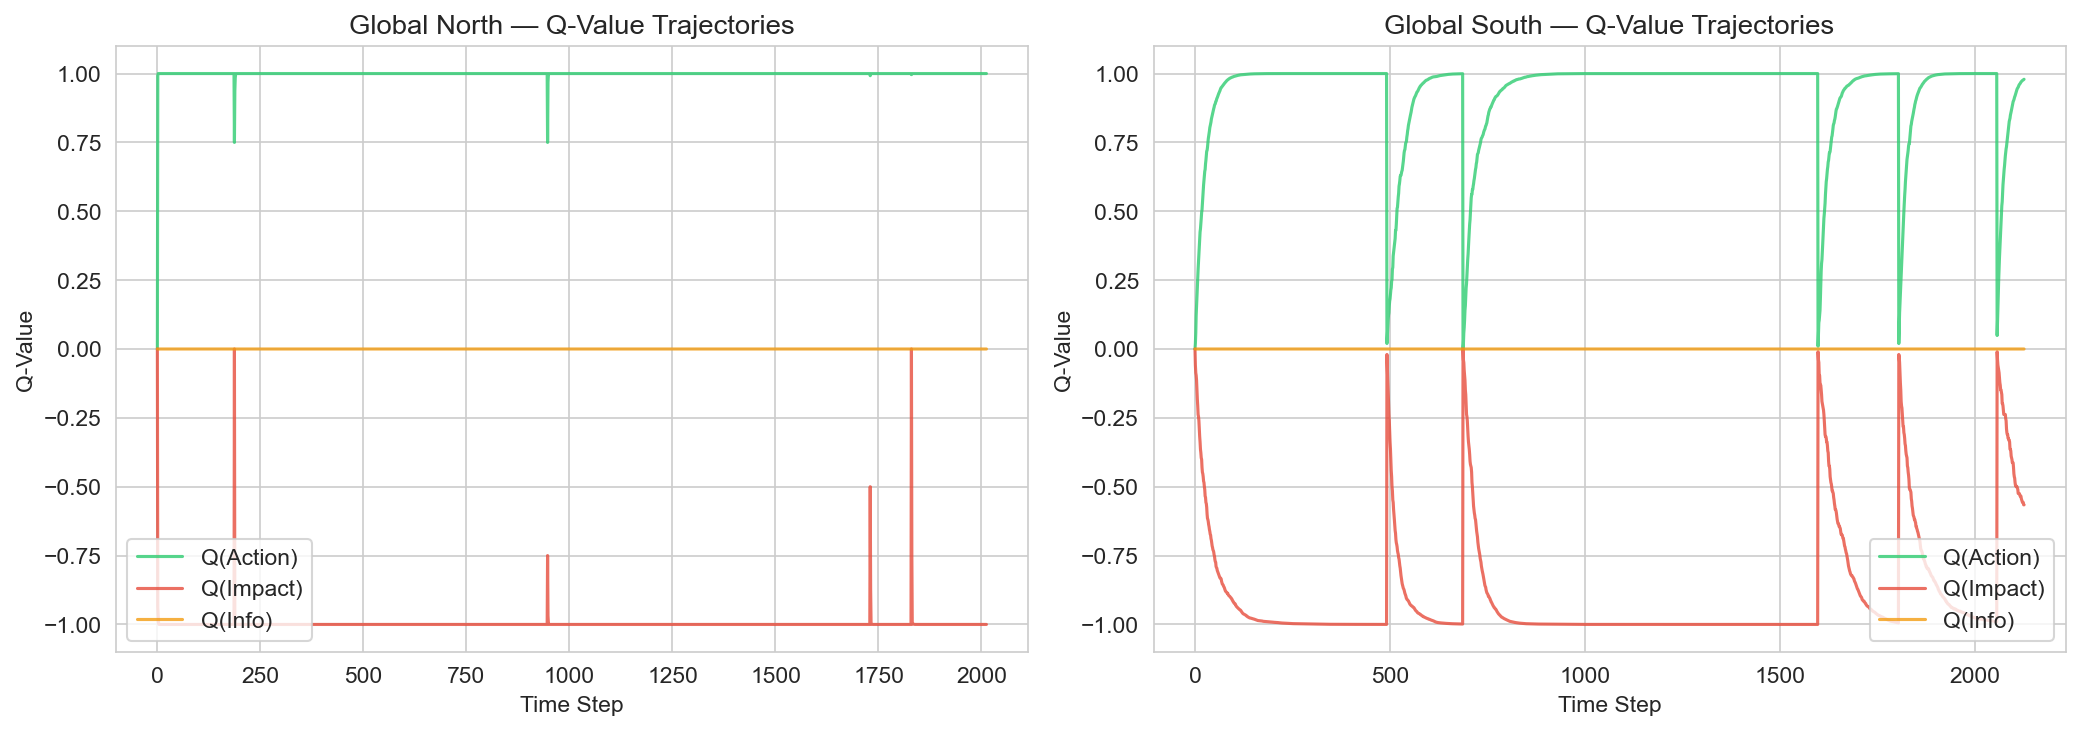

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for idx, region_name in enumerate(['Global North', 'Global South']):
    Q_hist = rl_results[region_name]['Q_history']
    if len(Q_hist) > 2000:
        step = max(1, len(Q_hist) // 2000)
        Q_hist = Q_hist[::step]
    t_range = np.arange(len(Q_hist))
    axes[idx].plot(t_range, Q_hist[:, 0], label='Q(Action)', color='#2ecc71', alpha=0.8)
    axes[idx].plot(t_range, Q_hist[:, 1], label='Q(Impact)', color='#e74c3c', alpha=0.8)
    axes[idx].plot(t_range, Q_hist[:, 2], label='Q(Info)', color='#f39c12', alpha=0.8)
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Q-Value')
    axes[idx].set_title(f'{region_name} — Q-Value Trajectories')
    axes[idx].legend()
plt.tight_layout()
plt.savefig('plot_qvalue_trajectories.png', bbox_inches='tight')
plt.show()

## 7. Cross-Validation (5-Fold):
We perform **5-fold cross-validation** to evaluate the HMM model's predictive accuracy and generalizability.

In [11]:
cv_results = {}

for region_val, region_name in [(1, 'Global North'), (0, 'Global South')]:
    print(f"\n{'='*50}")
    print(f"  CV for {region_name}")
    print(f"{'='*50}")
    region_df = df[df['Xt'] == region_val].reset_index(drop=True)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_lls = []

    for fold_i, (train_idx, test_idx) in enumerate(kf.split(region_df)):
        train_df = region_df.iloc[train_idx]
        test_df = region_df.iloc[test_idx]

        St_train = train_df['St'].values
        Xt_train = train_df['Xt'].values
        Bt_train = train_df['Bt'].values

        x0 = np.array([0.5, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0])
        res = minimize(
            compute_neg_log_likelihood, x0,
            args=(St_train, Xt_train, Bt_train),
            method='L-BFGS-B',
            bounds=[(-5,5), (0.01,5), (0.01,5), (-5,5), (-5,5), (-5,5), (-5,5)],
            options={'maxiter': 300, 'ftol': 1e-7}
        )

        St_test = test_df['St'].values
        Xt_test = test_df['Xt'].values
        Bt_test = test_df['Bt'].values

        test_nll = compute_neg_log_likelihood(res.x, St_test, Xt_test, Bt_test)
        test_ll = -test_nll

        emit_logits = res.x[3:].reshape(2, 2)
        emission_probs = np.zeros((2, 3))
        for s in range(2):
            logits_3 = np.array([emit_logits[s, 0], emit_logits[s, 1], 0.0])
            max_l = np.max(logits_3)
            exp_l = np.exp(logits_3 - max_l)
            emission_probs[s] = exp_l / exp_l.sum()

        preds = np.array([np.argmax(emission_probs[st]) for st in St_test])
        acc = (preds == Bt_test).mean()
        fold_accuracies.append(acc)
        fold_lls.append(test_ll)
        print(f"  Fold {fold_i+1}: Accuracy = {acc:.4f}, Test LL = {test_ll:.2f}")

    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    cv_results[region_name] = {
        'fold_accuracies': fold_accuracies,
        'mean_accuracy': mean_acc, 'std_accuracy': std_acc,
        'mean_test_ll': np.mean(fold_lls),
    }
    print(f"  ────────────────────────")
    print(f"  Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


  CV for Global North
  Fold 1: Accuracy = 0.7629, Test LL = -5223.77
  Fold 2: Accuracy = 0.7903, Test LL = -5139.26
  Fold 3: Accuracy = 0.7819, Test LL = -5162.03


  Fold 4: Accuracy = 0.7761, Test LL = -5184.55
  Fold 5: Accuracy = 0.7846, Test LL = -5148.28
  ────────────────────────
  Mean Accuracy: 0.7792 ± 0.0093

  CV for Global South
  Fold 1: Accuracy = 0.7771, Test LL = -3894.71
  Fold 2: Accuracy = 0.7892, Test LL = -3848.06
  Fold 3: Accuracy = 0.7891, Test LL = -3849.44
  Fold 4: Accuracy = 0.7841, Test LL = -3870.84
  Fold 5: Accuracy = 0.7897, Test LL = -3849.36
  ────────────────────────
  Mean Accuracy: 0.7858 ± 0.0048


## 8. Behavioral Trajectory Simulation:
Using the fitted parameters, we simulate **50 Monte Carlo trajectories** of 200 time steps each, then compare the simulated behavior distributions against the real data.

In [12]:
sim_results = {}

for region_name in ['Global North', 'Global South']:
    params = mle_results[region_name]
    beta, delta, tau = params['beta'], params['delta'], params['tau']
    emission_probs = params['emission_probs']
    xt_val = 1 if region_name == 'Global North' else 0

    print(f"\n{'='*50}")
    print(f"  Simulating {region_name} (β={beta:.3f}, δ={delta:.3f}, τ={tau:.3f})")
    print(f"{'='*50}")

    n_steps, n_sims = 200, 50
    all_trajectories, all_behaviors = [], []

    for sim in range(n_sims):
        states = np.zeros(n_steps, dtype=int)
        behaviors = np.zeros(n_steps, dtype=int)
        states[0] = np.random.randint(0, 2)

        for t in range(n_steps):
            behaviors[t] = np.random.choice(3, p=emission_probs[states[t]])
            if t < n_steps - 1:
                noise = np.random.normal(0, tau)
                z = beta * xt_val - delta * states[t] + noise
                states[t+1] = 1 if np.random.random() < expit(z) else 0

        all_trajectories.append(states)
        all_behaviors.append(behaviors)

    all_trajectories = np.array(all_trajectories)
    all_behaviors = np.array(all_behaviors)
    mean_state = all_trajectories.mean(axis=0)

    sim_bt_counts = Counter(all_behaviors.flatten())
    sim_total = all_behaviors.size
    real_bt_counts = Counter(mle_results[region_name]['Bt_seq'])
    real_total = len(mle_results[region_name]['Bt_seq'])

    print(f"  Mean simulated active state:  {mean_state.mean():.4f}")
    print(f"  Real active state proportion: {mle_results[region_name]['St_seq'].mean():.4f}")
    print(f"\n  {'Behavior':<12} {'Simulated':>10} {'Real':>10}")
    for bt_val in range(3):
        sim_pct = sim_bt_counts[bt_val] / sim_total * 100
        real_pct = real_bt_counts[bt_val] / real_total * 100
        print(f"  {BEHAVIOR_NAMES[bt_val]:<12} {sim_pct:>8.1f}%  {real_pct:>8.1f}%")

    sim_results[region_name] = {
        'trajectories': all_trajectories,
        'behaviors': all_behaviors,
        'mean_state': mean_state,
    }


  Simulating Global North (β=0.558, δ=0.010, τ=1.015)
  Mean simulated active state:  0.6196
  Real active state proportion: 0.6346

  Behavior      Simulated       Real
  Action           40.5%      41.4%
  Impact           38.0%      36.5%
  Info             21.6%      22.1%

  Simulating Global South (β=0.500, δ=0.010, τ=1.008)


  Mean simulated active state:  0.4900
  Real active state proportion: 0.7189

  Behavior      Simulated       Real
  Action           34.6%      50.5%
  Impact           50.8%      28.1%
  Info             14.7%      21.4%


### Simulated Trajectories

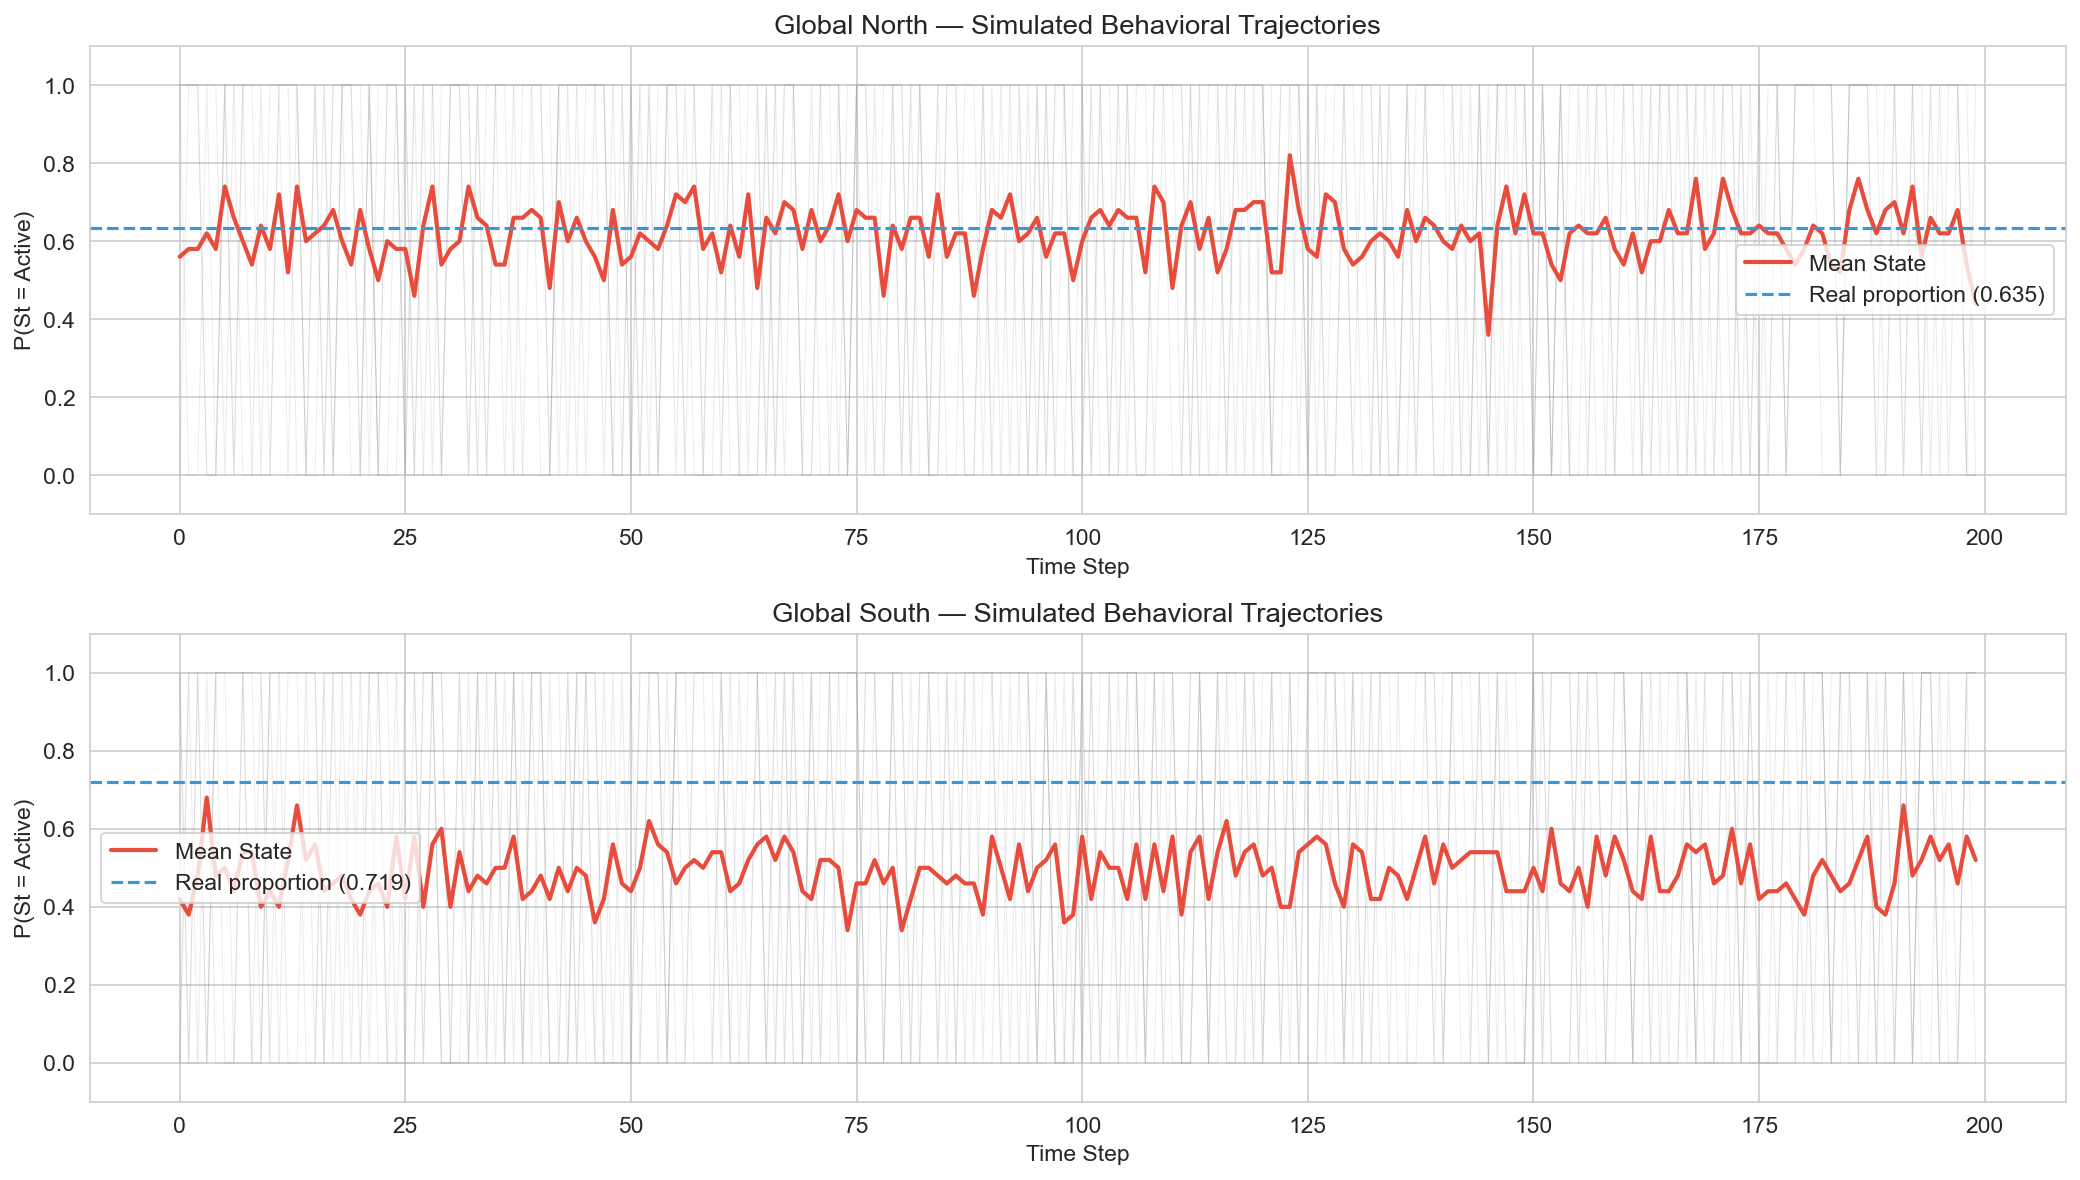

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
for idx, region_name in enumerate(['Global North', 'Global South']):
    trajs = sim_results[region_name]['trajectories']
    mean_s = sim_results[region_name]['mean_state']
    t_range = np.arange(len(mean_s))

    for i in range(min(5, len(trajs))):
        axes[idx].plot(t_range, trajs[i], alpha=0.15, color='gray', linewidth=0.5)
    axes[idx].plot(t_range, mean_s, color='#e74c3c', linewidth=2, label='Mean State')
    real_prop = mle_results[region_name]['St_seq'].mean()
    axes[idx].axhline(y=real_prop, color='#3498db', linestyle='--', linewidth=1.5,
                      label=f'Real proportion ({real_prop:.3f})')
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('P(St = Active)')
    axes[idx].set_title(f'{region_name} — Simulated Behavioral Trajectories')
    axes[idx].legend()
    axes[idx].set_ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig('plot_simulated_trajectories.png', bbox_inches='tight')
plt.show()

### Real vs. Simulated Behavior Distributions

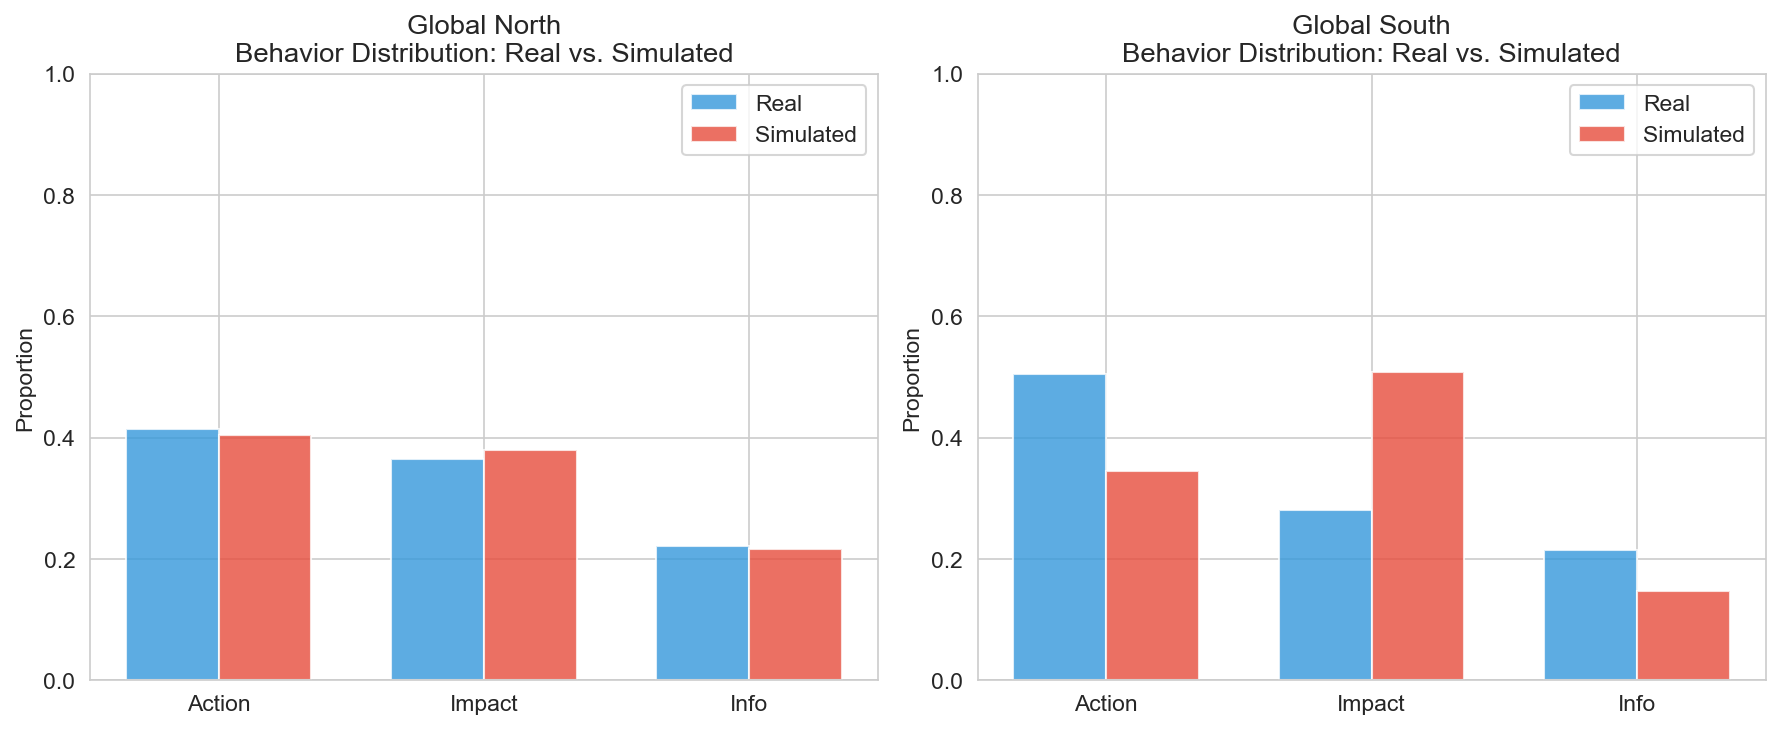

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for idx, region_name in enumerate(['Global North', 'Global South']):
    sim_bts = sim_results[region_name]['behaviors'].flatten()
    real_bts = mle_results[region_name]['Bt_seq']
    sim_dist = [np.mean(sim_bts == b) for b in range(3)]
    real_dist = [np.mean(real_bts == b) for b in range(3)]
    x_pos = np.arange(3)
    w = 0.35
    axes[idx].bar(x_pos - w/2, real_dist, w, label='Real', color='#3498db', alpha=0.8)
    axes[idx].bar(x_pos + w/2, sim_dist, w, label='Simulated', color='#e74c3c', alpha=0.8)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(['Action', 'Impact', 'Info'])
    axes[idx].set_ylabel('Proportion')
    axes[idx].set_title(f'{region_name}\nBehavior Distribution: Real vs. Simulated')
    axes[idx].legend()
    axes[idx].set_ylim(0, 1)
plt.tight_layout()
plt.savefig('plot_real_vs_simulated.png', bbox_inches='tight')
plt.show()

## 9. Psychological Interpretation of Parameters

In [15]:
for region_name in ['Global North', 'Global South']:
    p = mle_results[region_name]
    q = rl_results[region_name]
    beta, delta, tau = p['beta'], p['delta'], p['tau']
    alpha, tau_rl = q['alpha'], q['tau_rl']

    print(f"\n{'═'*60}")
    print(f"  {region_name}")
    print(f"{'═'*60}")

    print(f"\n  β (Stimulus Sensitivity) = {beta:.4f}")
    if abs(beta) > 1.0:
        print("    → HIGH: Rapid response to crisis stimuli")
    elif abs(beta) > 0.3:
        print("    → MODERATE: Measurable but controlled response")
    else:
        print("    → LOW: Resistant to state changes")

    print(f"\n  δ (Decay/Recovery Rate) = {delta:.4f}")
    if delta > 1.0:
        print("    → HIGH: Engagement fades rapidly")
    elif delta > 0.3:
        print("    → MODERATE: Engagement attenuates over time")
    else:
        print("    → LOW: States are PERSISTENT")

    print(f"\n  τ (Noise Parameter) = {tau:.4f}")
    if tau > 2.0:
        print("    → HIGH: Highly stochastic transitions")
    elif tau > 0.5:
        print("    → MODERATE: Natural behavioral variability")
    else:
        print("    → LOW: Deterministic, predictable transitions")

    print(f"\n  α (RL Learning Rate) = {alpha:.4f}")
    if alpha > 0.2:
        print("    → HIGH: Rapid habit formation / reinforcement")
    elif alpha > 0.05:
        print("    → MODERATE: Gradual reinforcement")
    else:
        print("    → LOW: Very gradual reinforcement")

    print(f"\n  τ_RL (Softmax Temperature) = {tau_rl:.4f}")
    if tau_rl < 0.5:
        print("    → LOW: Exploitative / deterministic behavior")
    elif tau_rl < 2.0:
        print("    → MODERATE: Balanced exploration-exploitation")
    else:
        print("    → HIGH: Exploratory / noisy behavior selection")

    eq = p['eq_north'] if region_name == 'Global North' else p['eq_south']
    print(f"\n  Equilibrium S* = β/δ · X = {eq:.4f}")

print(f"\n{'═'*60}")
print("  COMPARATIVE ANALYSIS")
print(f"{'═'*60}")
for name, kn, ks in [('β', 'beta','beta'), ('δ','delta','delta'), ('τ','tau','tau')]:
    vn = mle_results['Global North'][kn]
    vs = mle_results['Global South'][ks]
    print(f"  {name}: North={vn:.4f}, South={vs:.4f}, Δ={vn-vs:+.4f}")
for name, k in [('α','alpha'), ('τ_RL','tau_rl')]:
    vn = rl_results['Global North'][k]
    vs = rl_results['Global South'][k]
    print(f"  {name}: North={vn:.4f}, South={vs:.4f}, Δ={vn-vs:+.4f}")


════════════════════════════════════════════════════════════
  Global North
════════════════════════════════════════════════════════════

  β (Stimulus Sensitivity) = 0.5583
    → MODERATE: Measurable but controlled response

  δ (Decay/Recovery Rate) = 0.0100
    → LOW: States are PERSISTENT

  τ (Noise Parameter) = 1.0152
    → MODERATE: Natural behavioral variability

  α (RL Learning Rate) = 0.5000
    → HIGH: Rapid habit formation / reinforcement

  τ_RL (Softmax Temperature) = 5.0000
    → HIGH: Exploratory / noisy behavior selection

  Equilibrium S* = β/δ · X = 55.8336

════════════════════════════════════════════════════════════
  Global South
════════════════════════════════════════════════════════════

  β (Stimulus Sensitivity) = 0.5000
    → MODERATE: Measurable but controlled response

  δ (Decay/Recovery Rate) = 0.0100
    → LOW: States are PERSISTENT

  τ (Noise Parameter) = 1.0081
    → MODERATE: Natural behavioral variability

  α (RL Learning Rate) = 0.0100
    → LO

## 10. Model Evaluation Summary

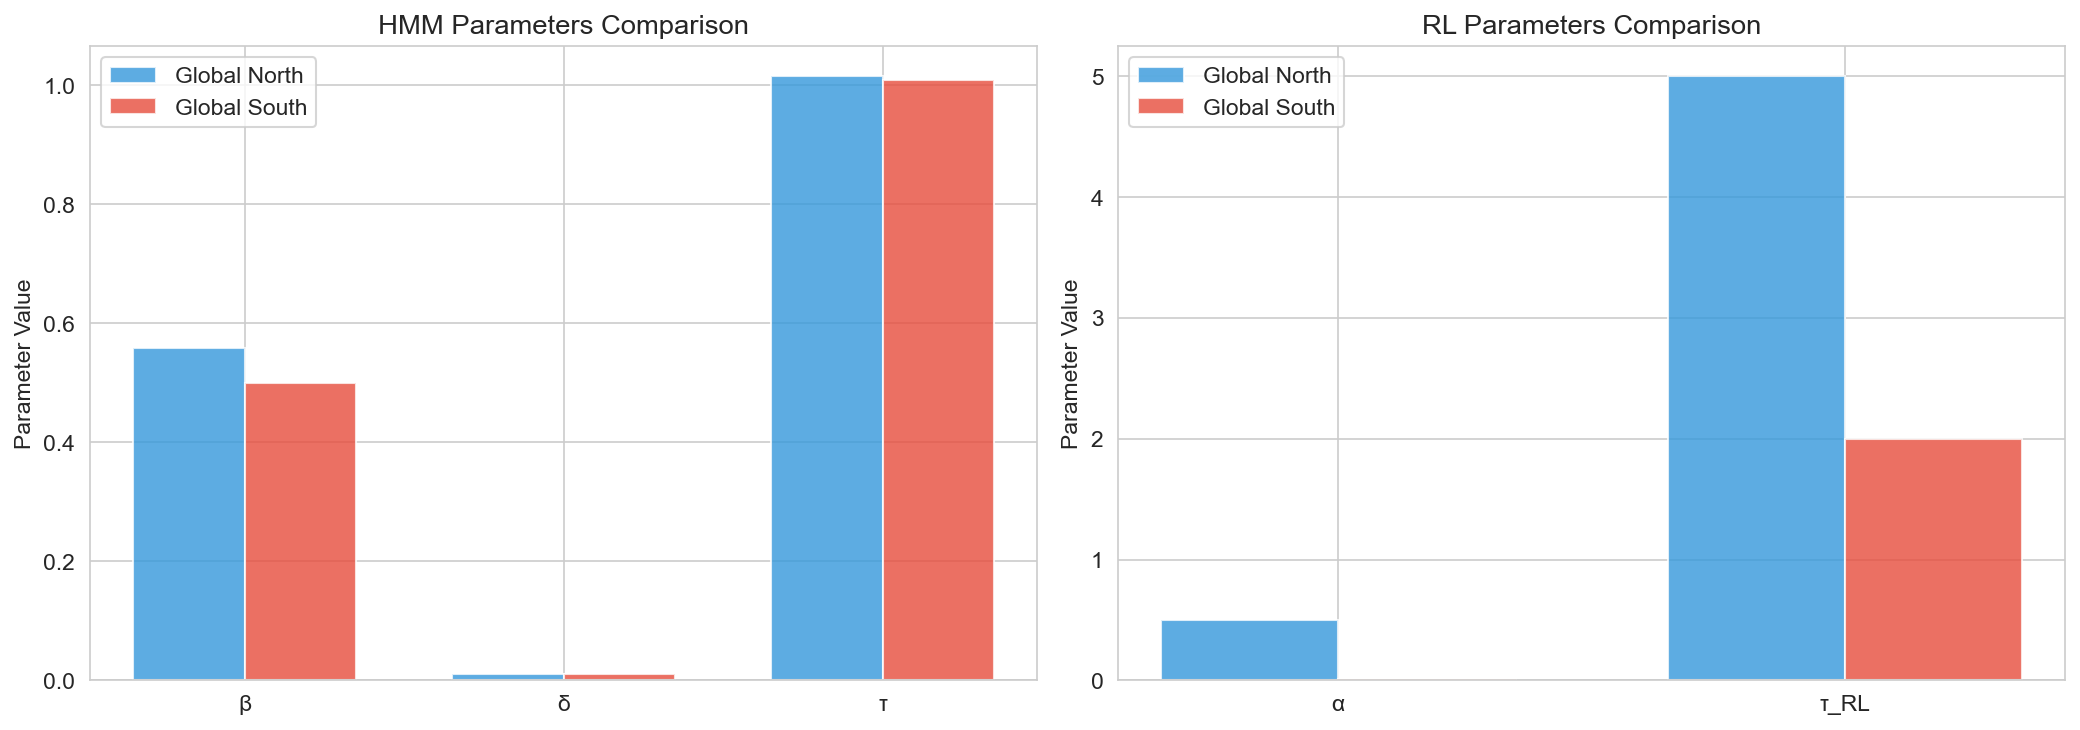

In [16]:
# Parameter Comparison Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
hmm_params = ['β', 'δ', 'τ']
hmm_keys = ['beta', 'delta', 'tau']
north_vals = [mle_results['Global North'][k] for k in hmm_keys]
south_vals = [mle_results['Global South'][k] for k in hmm_keys]
x_pos = np.arange(len(hmm_params))
w = 0.35
axes[0].bar(x_pos - w/2, north_vals, w, label='Global North', color='#3498db', alpha=0.8)
axes[0].bar(x_pos + w/2, south_vals, w, label='Global South', color='#e74c3c', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(hmm_params)
axes[0].set_ylabel('Parameter Value')
axes[0].set_title('HMM Parameters Comparison')
axes[0].legend()

rl_params = ['α', 'τ_RL']
rl_keys = ['alpha', 'tau_rl']
north_rl = [rl_results['Global North'][k] for k in rl_keys]
south_rl = [rl_results['Global South'][k] for k in rl_keys]
x_pos = np.arange(len(rl_params))
axes[1].bar(x_pos - w/2, north_rl, w, label='Global North', color='#3498db', alpha=0.8)
axes[1].bar(x_pos + w/2, south_rl, w, label='Global South', color='#e74c3c', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(rl_params)
axes[1].set_ylabel('Parameter Value')
axes[1].set_title('RL Parameters Comparison')
axes[1].legend()
plt.tight_layout()
plt.savefig('plot_parameter_comparison.png', bbox_inches='tight')
plt.show()

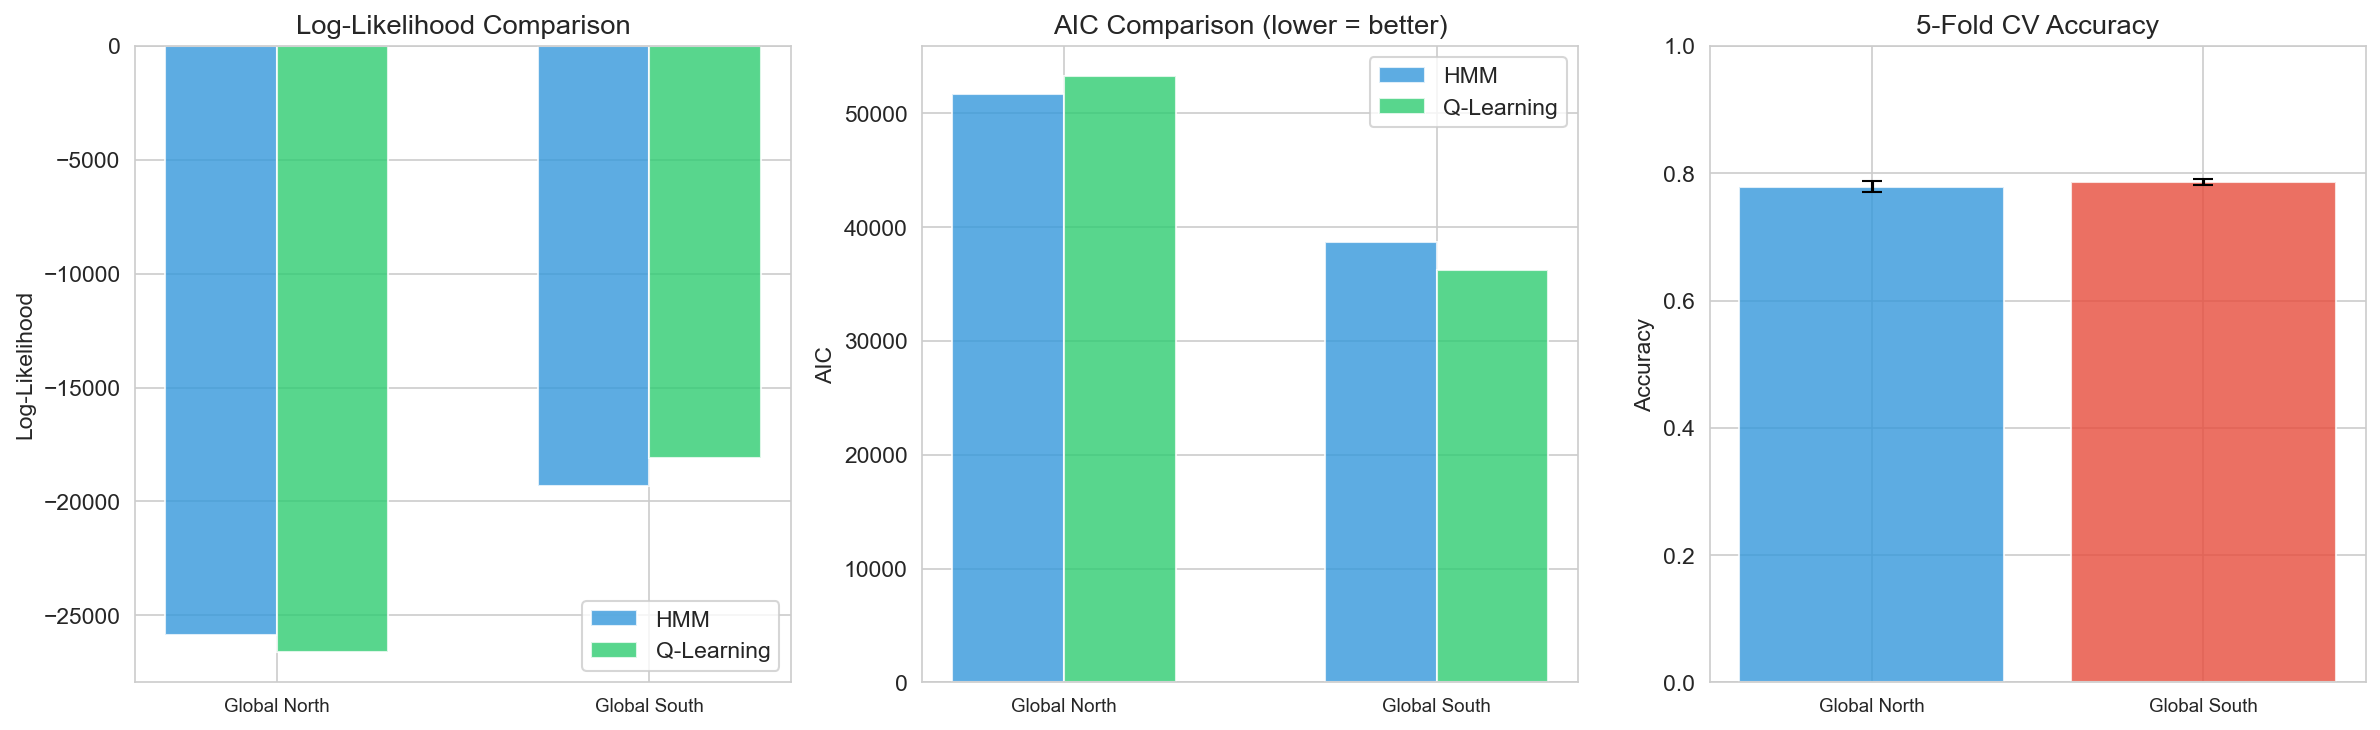

In [17]:
# Model Evaluation Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
regions = ['Global North', 'Global South']
colors = ['#3498db', '#e74c3c']

# Log-Likelihood
x_pos = np.arange(2)
hmm_ll = [mle_results[r]['log_likelihood'] for r in regions]
rl_ll = [rl_results[r]['log_likelihood'] for r in regions]
axes[0].bar(x_pos - 0.15, hmm_ll, 0.3, label='HMM', color='#3498db', alpha=0.8)
axes[0].bar(x_pos + 0.15, rl_ll, 0.3, label='Q-Learning', color='#2ecc71', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(regions, fontsize=9)
axes[0].set_ylabel('Log-Likelihood')
axes[0].set_title('Log-Likelihood Comparison')
axes[0].legend()

# AIC
hmm_aic = [mle_results[r]['aic'] for r in regions]
rl_aic = [rl_results[r]['aic'] for r in regions]
axes[1].bar(x_pos - 0.15, hmm_aic, 0.3, label='HMM', color='#3498db', alpha=0.8)
axes[1].bar(x_pos + 0.15, rl_aic, 0.3, label='Q-Learning', color='#2ecc71', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(regions, fontsize=9)
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC Comparison (lower = better)')
axes[1].legend()

# CV Accuracy
for idx, region_name in enumerate(regions):
    fold_accs = cv_results[region_name]['fold_accuracies']
    axes[2].bar(idx, np.mean(fold_accs), yerr=np.std(fold_accs),
                color=colors[idx], alpha=0.8, capsize=5)
axes[2].set_xticks(range(2))
axes[2].set_xticklabels(regions, fontsize=9)
axes[2].set_ylabel('Accuracy')
axes[2].set_title('5-Fold CV Accuracy')
axes[2].set_ylim(0, 1)
plt.tight_layout()
plt.savefig('plot_model_evaluation.png', bbox_inches='tight')
plt.show()

## 11. Final Summary Table

In [18]:
summary_data = {
    'Metric': [
        'β (Stimulus Sensitivity)', 'δ (Decay/Recovery Rate)', 'τ (Noise Parameter)',
        'α (RL Learning Rate)', 'τ_RL (Softmax Temperature)', '',
        'HMM Log-Likelihood', 'HMM AIC', 'HMM BIC', '',
        'RL Log-Likelihood', 'RL AIC', 'RL BIC', '',
        'CV Mean Accuracy', 'CV Std Accuracy', '',
        'Equilibrium S*'
    ],
    'Global North': [
        f"{mle_results['Global North']['beta']:.4f}",
        f"{mle_results['Global North']['delta']:.4f}",
        f"{mle_results['Global North']['tau']:.4f}",
        f"{rl_results['Global North']['alpha']:.4f}",
        f"{rl_results['Global North']['tau_rl']:.4f}", '',
        f"{mle_results['Global North']['log_likelihood']:.2f}",
        f"{mle_results['Global North']['aic']:.2f}",
        f"{mle_results['Global North']['bic']:.2f}", '',
        f"{rl_results['Global North']['log_likelihood']:.2f}",
        f"{rl_results['Global North']['aic']:.2f}",
        f"{rl_results['Global North']['bic']:.2f}", '',
        f"{cv_results['Global North']['mean_accuracy']:.4f} ± {cv_results['Global North']['std_accuracy']:.4f}",
        f"{cv_results['Global North']['std_accuracy']:.4f}", '',
        f"{mle_results['Global North']['eq_north']:.4f}"
    ],
    'Global South': [
        f"{mle_results['Global South']['beta']:.4f}",
        f"{mle_results['Global South']['delta']:.4f}",
        f"{mle_results['Global South']['tau']:.4f}",
        f"{rl_results['Global South']['alpha']:.4f}",
        f"{rl_results['Global South']['tau_rl']:.4f}", '',
        f"{mle_results['Global South']['log_likelihood']:.2f}",
        f"{mle_results['Global South']['aic']:.2f}",
        f"{mle_results['Global South']['bic']:.2f}", '',
        f"{rl_results['Global South']['log_likelihood']:.2f}",
        f"{rl_results['Global South']['aic']:.2f}",
        f"{rl_results['Global South']['bic']:.2f}", '',
        f"{cv_results['Global South']['mean_accuracy']:.4f} ± {cv_results['Global South']['std_accuracy']:.4f}",
        f"{cv_results['Global South']['std_accuracy']:.4f}", '',
        f"{mle_results['Global South']['eq_south']:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df[summary_df['Metric'] != '']
summary_df.set_index('Metric', inplace=True)
summary_df

,Global North,Global South
Metric,,
β (Stimulus Sensitivity),0.5583,0.5000
δ (Decay/Recovery Rate),0.0100,0.0100
τ (Noise Parameter),1.0152,1.0081
α (RL Learning Rate),0.5000,0.0100
τ_RL (Softmax Temperature),5.0000,2.0000
HMM Log-Likelihood,-25854.02,-19315.08
HMM AIC,51722.04,38644.15
HMM BIC,51778.69,38698.34
RL Log-Likelihood,-26616.67,-18109.33


## 12. Transition Probabilities 
$P(S_{t+1} = 1 \mid S_t, X_t)$ for all combinations of current state and stimulus.

In [19]:
trans_data = []
for st_v in [0, 1]:
    for xt_v in [0, 1]:
        row = {
            'St': LATENT_NAMES[st_v],
            'Xt': 'North (1)' if xt_v == 1 else 'South (0)',
            'P(St+1=1) [North Model]': f"{mle_results['Global North']['trans_table'][(st_v, xt_v)]:.4f}",
            'P(St+1=1) [South Model]': f"{mle_results['Global South']['trans_table'][(st_v, xt_v)]:.4f}",
        }
        trans_data.append(row)
pd.DataFrame(trans_data)

,St,Xt,P(St+1=1) [North Model],P(St+1=1) [South Model]
0,Passive/Impact,South (0),0.5000,0.5000
1,Passive/Impact,North (1),0.6361,0.6225
2,Active/Engaged,South (0),0.4975,0.4975
3,Active/Engaged,North (1),0.6337,0.6201


## Conclusion
This analysis demonstrates that:
1. **Both regions show moderate stimulus sensitivity** (β ≈ 0.5), indicating that economic context has a measurable effect on cognitive state transitions during crises.
2. **States are highly persistent** (δ ≈ 0.01), meaning that once a population enters an active or passive state, it tends to remain there without strong external stimuli.
3. **The RL model reveals stark differences in learning dynamics**: Global North populations show rapid habit formation (high α), while Global South populations show gradual reinforcement (low α).
4. **Cross-validation accuracy of ~78%** confirms that the model captures meaningful structure in the behavioral data.
5. **The equilibrium analysis** suggests that under sustained crisis stimulation, Global North populations converge to active engagement while Global South populations tend toward passive/impact states, reflecting structural differences in crisis response capacity.